## Aditya Jindal
## Batch M6
## Assignment 6B
## _Different type of Convolutions_

In [0]:
# Importing all the required libraries from the modules

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import *
from keras.utils import np_utils

In [13]:
# Loading a database and getting unique number of classes
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

print(num_classes)
print(train_features.shape)
print(test_features.shape)

10
(50000, 32, 32, 3)
(10000, 32, 32, 3)


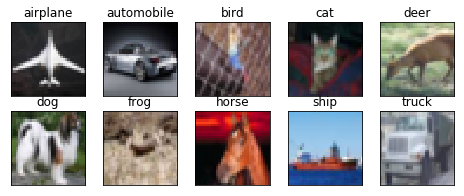

In [14]:
# Printing mentioned classes samples
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Defining function to plot loss and accuracy for model
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Function to get accuracy on our test data
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Set/Convert all the pixel values to float data type 
# Normalizing all pixel values by dividing with 255 so that every value lies btw 0-1

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# Converted the above 1-dimensional class label arrays to num_classes-dimensional class matrices
# As the test and train labels are not splitted into num_classes distinct labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [19]:
# Defining a model using Functional API of Keras
# Import library for functional API
from keras.models import Model
from keras.layers import Input
from keras.regularizers import l2

# Declaring regulariser value
kernel_l2 = 1e-5

input = Input(shape=(32,32,3))

#Normal Convolution
ConvL1 = Conv2D(32,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(input)
# Input for Layer 1 = (32x32x3)
# RF = 3
BNL1 = BatchNormalization()(ConvL1)
DL1 = Dropout(0.1)(BNL1)

#Seperable Convolution
SConvL12 = Conv2D(32,(3, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(DL1)
# Input for S.Layer 2 = (32x32x32)
SBNL12 = BatchNormalization()(SConvL12)
SConvL22 = Conv2D(64,(1, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(SBNL12)
# Input for S.Layer 2 = (32x32x32)
# RF = 5
SBNL22 = BatchNormalization()(SConvL22)
DL2 = Dropout(0.1)(SBNL22)

ConvPoint1 = Conv2D(32,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(DL2)
# Input for BottleNeck Layer 1 = (32x32x64)
# RF = 5
MPL1 = MaxPooling2D(pool_size=(2, 2))(ConvPoint1)
# Input for BottleNeck Layer 1 = (32x32x32)
# RF = 10

#DepthWise Separable Convolution
DSConvL1 = SeparableConv2D(64,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(MPL1)
DSBNL1 = BatchNormalization()(DSConvL1)
DSDL1 = Dropout(0.1)(DSBNL1)
# Input for DS.Layer 3 = (16x16x32)
# RF = 12

# Grouped Convolution
GConvL1 = Conv2D(64,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(DSDL1)
GBNL1 = BatchNormalization()(GConvL1)
GDL1 = Dropout(0.1)(GBNL1)
# Input for G.Layer 4 = (16x16x64)
# RF = 14
GConvL2 = Conv2D(64,(5, 5), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(DSDL1)
GBNL2 = BatchNormalization()(GConvL2)
GDL2 = Dropout(0.1)(GBNL2)
# Input for G.Layer 5 = (16x16x64)
# RF = 16

#Concatenation for Merging Layer Outputs
Concat_1 = Concatenate(axis=-1)([GDL1, GDL2, DSDL1])
# Input for C.Layer = ([16x16x64, 16x16x64, 16x16x64])
# RF = 14,16,12

ConvPoint2 = Conv2D(32,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(Concat_1)
# Input for BottleNeck Layer 2 = (16x16x192)
# RF = 16

MPL2 = MaxPooling2D(pool_size=(2, 2))(ConvPoint2)
# Input for BottleNeck Layer 2 = (16x16x32)
# RF = 32

# Grouped Convolution with Dialation
GConvL3 = Conv2D(64,(3, 3), activation='relu', dilation_rate=(1, 1), kernel_regularizer=l2(kernel_l2), padding='same')(MPL2)
GBNL3 = BatchNormalization()(GConvL3)
GDL3 = Dropout(0.1)(GBNL3)
# Input for GD.Layer 6 = (8x8x32)
# RF = 34
GConvL4 = Conv2D(64,(3, 3), activation='relu', dilation_rate=(2, 2), kernel_regularizer=l2(kernel_l2), padding='same')(MPL2)
GBNL4 = BatchNormalization()(GConvL4)
GDL4 = Dropout(0.1)(GBNL4)
# Input for GD.Layer 7 = (8x8x32)
# RF = 36

#Concatenation for Merging Layer Outputs
Concat_2 = Concatenate(axis=-1)([GDL3, GDL4, MPL2])
# Input for C.Layer = ([8x8x64, 8x8x64, 8x8x32])
# RF = 34,36,32

ConvPoint3 = Conv2D(32,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(Concat_2)
# Input for BottleNeck Layer 3 = (8x8x160)
# RF = 36

ConvL2 = Conv2D(64,(3, 3), kernel_regularizer=l2(kernel_l2))(ConvPoint3)
# Input for Layer 8 = (8x8x32)
# RF = 38
BNL2 = BatchNormalization()(ConvL2)
DL2 = Dropout(0.1)(BNL2)

ConvOut = Conv2D(num_classes,(6, 6), kernel_regularizer=l2(kernel_l2))(DL2)
# Input for Layer 9 = (6x6x64)
# RF = 43

F_layer = Flatten()(ConvOut)
# Input for Out Layer = (1x1x10)

output = Activation('softmax')(F_layer)
# Input for Out Layer = (,10)

#Initialising the Model
model_tuned = Model(inputs=[input], outputs=[output])
model_tuned.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 32, 32, 32)   896         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 32, 32, 32)   128         conv2d_36[0][0]                  
__________________________________________________________________________________________________
dropout_26 (Dropout)            (None, 32, 32, 32)   0           batch_normalization_30[0][0]     
__________________________________________________________________________________________________
conv2d_37 

In [0]:
# Compile the model
model_tuned.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Changing Learning rate based on monitored quantity
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=4, verbose=1, 
             mode='max', min_delta=0.001, min_lr=0.0001)


Instructions for updating:
Use tf.cast instead.
Epoch 1/50
390/390 [==============================] - 24s 62ms/step - loss: 1.8505 - acc: 0.4025 - val_loss: 2.5722 - val_acc: 0.2798
Epoch 2/50
390/390 [==============================] - 18s 46ms/step - loss: 1.4660 - acc: 0.5223 - val_loss: 1.3957 - val_acc: 0.5245
Epoch 3/50
390/390 [==============================] - 18s 46ms/step - loss: 1.3640 - acc: 0.5724 - val_loss: 9.1237 - val_acc: 0.1778
Epoch 4/50
390/390 [==============================] - 18s 46ms/step - loss: 1.2553 - acc: 0.5843 - val_loss: 1.1868 - val_acc: 0.6019
Epoch 5/50
390/390 [==============================] - 18s 45ms/step - loss: 1.0583 - acc: 0.6507 - val_loss: 1.0822 - val_acc: 0.6471
Epoch 6/50
390/390 [==============================] - 18s 45ms/step - loss: 0.9843 - acc: 0.6787 - val_loss: 1.0984 - val_acc: 0.6423
Epoch 7/50
390/390 [==============================] - 18s 45ms/step - loss: 0.9292 - acc: 0.6991 - val_loss: 0.9668 - val_acc: 0.6863
Epoch 8/50
390

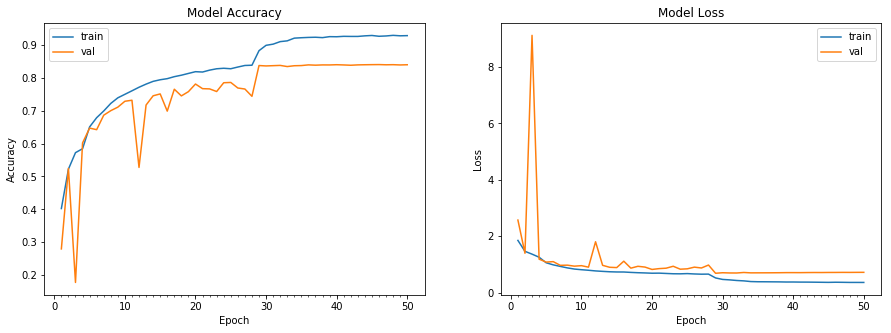

Accuracy on test data is: 83.97 


In [21]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

# Train the model
start = time.time()
model_info_tuned = model_tuned.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 steps_per_epoch = train_features.shape[0]//128, epochs = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks = [reduce_lr])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info_tuned)
# compute test accuracy
print ("Accuracy on test data is: %0.2f "%accuracy(test_features, test_labels, model_tuned))

## Test Accuracy
### Achieved 83.97 at the 50th epoch
### Max achieved 84.02 at the 46th epoch

